In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../gene-signature-ml-pipeline')

In [2]:
import os
import glob
import numpy as np
import pandas as pd

In [3]:
colors = dict(
    blue = '#4E79A7',
    orange = '#F28E2B',
    green = '#59A14F',
    red = '#E15759',
    purple = '#B07AA1',
    pink = '#FF9DA7',
    gray = '#BAB0AC',
    yellow = '#EDC948',
    brown = '#9D7660',
    teal = '#499894',
    lightblue = '#A0CBE8'
)
palette = colors.keys()

In [4]:
# define directory and file paths
data_dir = os.path.abspath('/efs/liam/tb-gene-signature-data/wenhan-processed-data')
# load ACS metadata
df_metadata = pd.read_csv(os.path.join(data_dir, 'GSE79362_GSE103147_MultivariateModel_Info.csv'), index_col=0)
# define outcome as categorical variable
df_metadata['group'] = pd.Categorical(
    df_metadata['group'].astype(str).str.replace('.0', '', regex=False),
    categories=['0', '1', '2', '3', '4', '5'],
    ordered=True
)
# order by outcome group
df_metadata = df_metadata.sort_values('group')
# munge metadata variables
df_metadata['participant_id'] = pd.Categorical(df_metadata['ID'])
df_metadata['group_name'] = pd.Categorical(df_metadata['groupName'])
df_metadata['sample_time'] = pd.Categorical(df_metadata['sampleTime'])
df_metadata['pp_time_to_diagnosis'] = df_metadata['PP_time_to_diagnosis'].replace('---', np.nan).astype(float)
df_metadata['bin'] = df_metadata['bin'].astype(int)
#df_metadata['is_female'] = (df_metadata['gender'] == 'female')
# drop extra columns
df_metadata = df_metadata.drop(['ID', 'groupName', 'sampleTime', 'PP_time_to_diagnosis'], axis=1)
# load Roger's gene set
gene_set_file = os.path.abspath('/home/liam.abbott/tb-gene-signature/results/roger-gene-set.txt')
gene_set = set(line.strip() for line in open(gene_set_file).readlines())
# load ACS expression features
df_features = pd.read_csv(os.path.join(data_dir, 'GSE79362_GSE103147_MultivariateModel_Exp_EachGene.csv'), index_col=0)
#df_features = df_features.loc[df_features.index.isin(gene_set)].T
df_features = df_features.T

## PIPELINE DEV

* [ ] threshold on AUC for stability scores
* [ ] plot stability scores vs lambdas for each feature
* [ ] plot correlation/mutual info between y and each feature vs stability score for the feature
* [ ] implement cross-validation random forest model after feature screening
* [ ] cross-validation on entire dataset to compare model architectures

In [5]:
from gene_signature_dataset import GeneSignatureDataset
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, SelectFromModel, \
    mutual_info_classif, mutual_info_regression
from sklearn.compose import ColumnTransformer, \
    make_column_selector, make_column_transformer
from sklearn.utils import resample
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from plotnine import *
from mizani.formatters import comma_format

In [6]:
X = df_metadata[['gender', 'age']].join(df_features)
y = df_metadata['group'].astype(int)

In [7]:
numeric_features = X.select_dtypes(
    include='number').columns
categorical_features = X.select_dtypes(
    include=object).columns
X = pd.get_dummies(X)
categorical_features = X.columns[
    X.columns.map(
        lambda x: x.split('_')[0] in categorical_features)]
features = numeric_features.union(categorical_features)
is_regression = is_numeric_dtype(y)
random_state = 111

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

In [10]:
dataset = GeneSignatureDataset(X, y, random_state=random_state)

In [11]:
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2)

In [15]:
stability_scores_max = train_dataset.compute_feature_stability_scores(method='max')

In [16]:
stability_path_plot_max = train_dataset.plot_feature_stability_scores_lambda_path(
    method='max', threshold=0.2, title='ACS cohort feature stability scores lambda path, max')

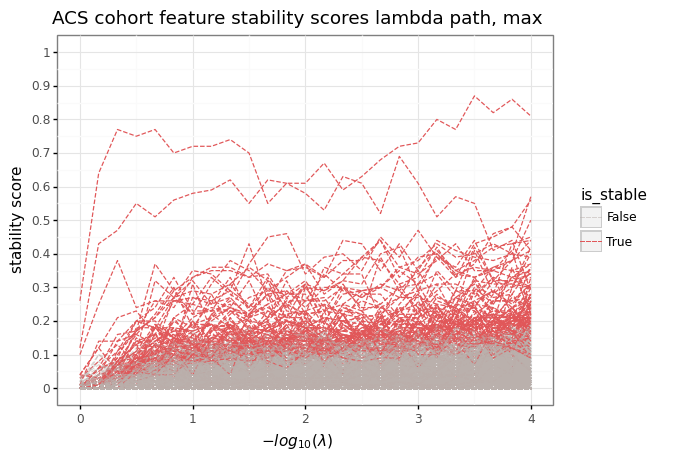

In [17]:
stability_path_plot_max.draw();

In [89]:
(stability_scores_max >= 0.2).sum()

110

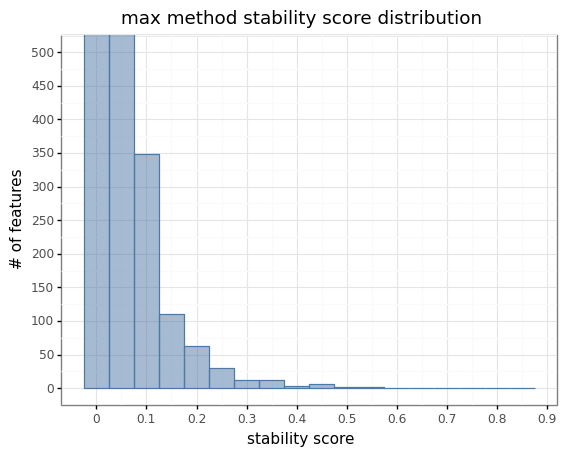

In [18]:
p = (
    ggplot(
        pd.DataFrame({
            'stability_scores': stability_scores_max
        })) +
    geom_histogram(
        aes(x='stability_scores'),
        binwidth=0.05,
        fill=colors['blue'],
        color=colors['blue'],
        alpha=0.5) +
    scale_x_continuous(
        breaks=np.arange(0, 1.1, 0.1)) +
    scale_y_continuous(
        breaks=np.arange(0, 501, 50),
        labels=comma_format()) +
    coord_cartesian(
        ylim=[0, 500]) +
    labs(
        x='stability score',
        y='# of features',
        title='max method stability score distribution') +
    theme_bw()
)
p.draw();

In [19]:
stability_scores_auc = train_dataset.compute_feature_stability_scores(method='auc', compute_lambda_path=False)

In [20]:
stability_path_plot_auc = train_dataset.plot_feature_stability_scores_lambda_path(
    method='auc', threshold=0.2, title='ACS cohort feature stability scores lambda path, auc')

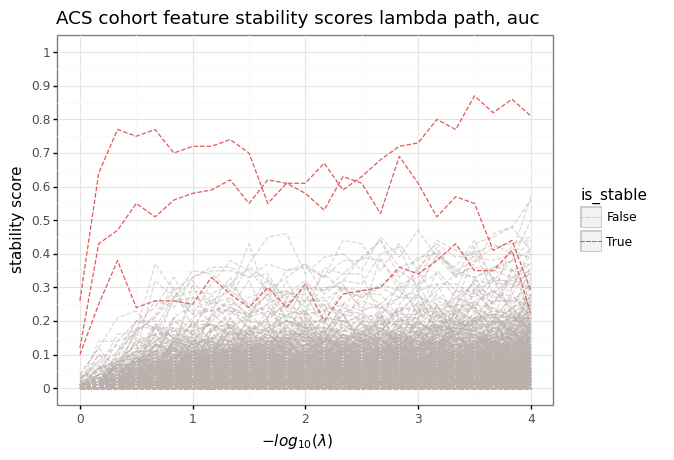

In [21]:
stability_path_plot_auc.draw();

In [22]:
(stability_scores_auc >= 0.2).sum()

3

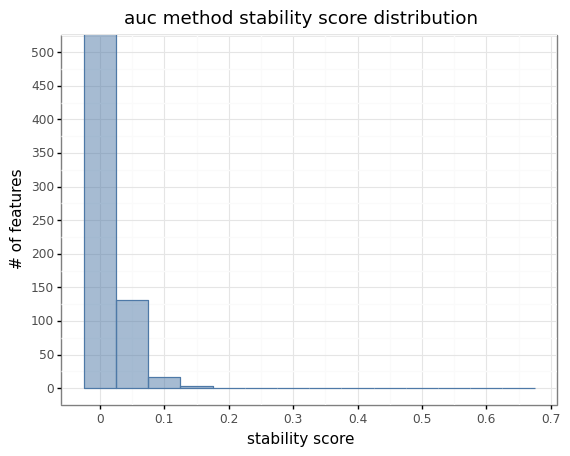

In [23]:
p = (
    ggplot(
        pd.DataFrame({
            'stability_scores': stability_scores_auc
        })) +
    geom_histogram(
        aes(x='stability_scores'),
        binwidth=0.05,
        fill=colors['blue'],
        color=colors['blue'],
        alpha=0.5) +
    scale_x_continuous(
        breaks=np.arange(0, 1.1, 0.1)) +
    scale_y_continuous(
        breaks=np.arange(0, 501, 50),
        labels=comma_format()) +
    coord_cartesian(
        ylim=[0, 500]) +
    labs(
        x='stability score',
        y='# of features',
        title='auc method stability score distribution') +
    theme_bw()
)
p.draw();

In [103]:
corrs = train_dataset.compute_featurewise_outcome_correlations(method='pearson')

In [104]:
p = train_dataset.plot_feature_stability_scores_vs_outcome_correlations()

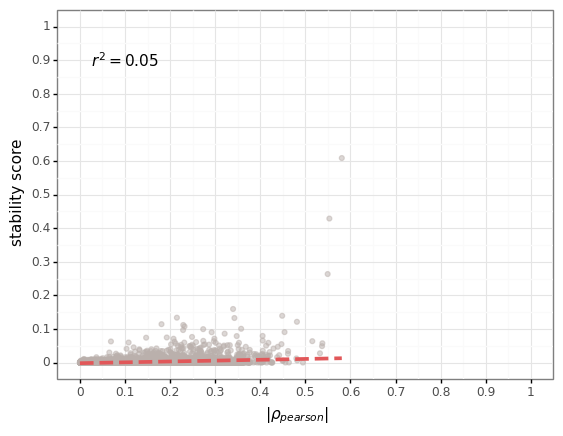

In [105]:
p.draw();